#Step 1: Import libraries

In [ ]:
!pip install squarify

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import squarify
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering
from matplotlib.colors import Normalize

# Step 2: Load RFM dataset

In [ ]:
rfm = pd.read_csv('/content/drive/MyDrive/DL07_K306_PhamHongPhat_LeThiNgocPhuong/Project1 - Customer Segmentation/2 - Data/rfm_table.csv')
rfm.head(5)

,Member_number,Recency,Frequency,Monetary
0,1000,35,5,53.80
1,1001,242,5,100.00
2,1002,122,4,70.30
3,1003,323,4,60.65
4,1004,28,8,204.96


# Step 3: Build Model

## A. Rule-Based Segmentation

### A.1: RFM Score Calculate

In [ ]:
df_rfm = rfm.copy()

In [ ]:
# Calculate Recency Scores (1-4)
# Lower recency values = higher scores (recent customers are better)

# Calculate Recency Score using quartiles
# Use qcut to divide into 4 equal-sized groups
df_rfm['R_Score'] = pd.qcut(df_rfm['Recency'],
                           q=4,
                           labels=False,
                           duplicates='drop')

# Reverse the scores for recency (lower recency should get higher score)
df_rfm['R_Score'] = 3 - df_rfm['R_Score']  # Convert 0,1,2,3 to 3,2,1,0
df_rfm['R_Score'] = df_rfm['R_Score'] + 1  # Convert to 1,2,3,4 scale

print("Recency Score Calculation:")
print("Recency ranges for each score:")
recency_ranges = df_rfm.groupby('R_Score')['Recency'].agg(['min', 'max', 'count'])
print(recency_ranges)

print(f"\nRecency Score distribution:")
print(df_rfm['R_Score'].value_counts().sort_index())

Recency Score Calculation:
Recency ranges for each score:
         min  max  count
R_Score                 
1        281  727    974
2        142  280    973
3         58  141    974
4          0   57    977

Recency Score distribution:
R_Score
1    974
2    973
3    974
4    977
Name: count, dtype: int64


In [ ]:
#Step 1C: Calculate Frequency Scores (1-4)
# Higher frequency values = higher scores (frequent customers are better)

# Calculate Frequency Score using quartiles
df_rfm['F_Score'] = pd.qcut(df_rfm['Frequency'],
                           q=4,
                           labels=False,
                           duplicates='drop')

# Convert to 1-4 scale (higher frequency = higher score)
df_rfm['F_Score'] = df_rfm['F_Score'] + 1

print("Frequency Score Calculation:")
print("Frequency ranges for each score:")
frequency_ranges = df_rfm.groupby('F_Score')['Frequency'].agg(['min', 'max', 'count'])
print(frequency_ranges)

print(f"\nFrequency Score distribution:")
print(df_rfm['F_Score'].value_counts().sort_index())

Frequency Score Calculation:
Frequency ranges for each score:
         min  max  count
F_Score                 
1          1    2   1038
2          3    4   1578
3          5    5    552
4          6   11    730

Frequency Score distribution:
F_Score
1    1038
2    1578
3     552
4     730
Name: count, dtype: int64


In [ ]:
# Calculate Monetary Scores (1-4)
# Higher monetary values = higher scores (high-value customers are better)

# Calculate Monetary Score using quartiles
df_rfm['M_Score'] = pd.qcut(df_rfm['Monetary'],
                           q=4,
                           labels=False,
                           duplicates='drop')

# Convert to 1-4 scale (higher monetary = higher score)
df_rfm['M_Score'] = df_rfm['M_Score'] + 1

print("Monetary Score Calculation:")
print("Monetary ranges for each score:")
monetary_ranges = df_rfm.groupby('M_Score')['Monetary'].agg(['min', 'max', 'count'])
print(monetary_ranges)

print(f"\nMonetary Score distribution:")
print(df_rfm['M_Score'].value_counts().sort_index())

Monetary Score Calculation:
Monetary ranges for each score:
            min     max  count
M_Score                       
1          1.30   43.80    975
2         43.84   74.90    980
3         74.95  115.28    968
4        115.30  375.31    975

Monetary Score distribution:
M_Score
1    975
2    980
3    968
4    975
Name: count, dtype: int64


#### Evaluation of RFM Scoring Results
#### Recency Score

| Score | Range (days) | Count |
| ----- | ------------ | ----- |
| 1     | 281 – 727    | 974   |
| 2     | 142 – 280    | 973   |
| 3     | 58 – 141     | 974   |
| 4     | 0 – 57       | 977   |

- Distribution is very balanced (≈ 975 customers in each group) → confirms correct quartile split

- Interpretation:
  - Score 4: very recent buyers (0–57 days).
  - Score 1: customers who haven’t purchased in a long time (≥ 281 days)

-> Strong segmentation for distinguishing “fresh” vs “inactive” customers

#### Frequency Score
| Score | Range (purchases) | Count |
| ----- | ----------------- | ----- |
| 1     | 1 – 2             | 1,038 |
| 2     | 3 – 4             | 1,578 |
| 3     | 5                 | 552   |
| 4     | 6 – 11            | 730   |

- Uneven distribution: majority fall in Score 2 (3–4 purchases), with 1,578 customers (~40%)
- Score 3 (exactly 5 purchases) is relatively small (552), since it only covers a narrow range
- Interpretation:
  - Most customers purchased only 3–4 times
  - Heavy repeat buyers (≥ 6 times) are a smaller group (~20%)

-> Indicates purchase frequency is skewed toward low-to-medium buyers

#### Monetary Score
| Score | Range (spending) | Count |
| ----- | ---------------- | ----- |
| 1     | 1.30 – 43.80     | 975   |
| 2     | 43.84 – 74.90    | 980   |
| 3     | 74.95 – 115.28   | 968   |
| 4     | 115.30 – 375.31  | 975   |

- Well-balanced distribution → nearly equal customers in each quartile
- Interpretation:
  - Score 4: top spenders (> 115.3)
  - Score 1: low spenders (< 43.8)
  
-> This variable provides a clean and even split for identifying high-value vs low-value customers

###Summary
- Recency: very balanced quartiles → excellent for spotting recent vs inactive customers
- Frequency: skewed distribution → most customers buy infrequently (≤ 4 times), showing retention is relatively weak
- Monetary: balanced → clear separation between low and high spenders

### A.2: Combine R, F, M into a signle RFM Score

In [ ]:
# Combine R, F, M into one RFM Score (string format e.g., "432")
df_rfm['RFM_Score'] = (
    df_rfm['R_Score'].astype(str) +
    df_rfm['F_Score'].astype(str) +
    df_rfm['M_Score'].astype(str)
)

# Also create a numeric RFM index if needed
df_rfm['RFM_Index'] = (
    df_rfm['R_Score']*100 +
    df_rfm['F_Score']*10 +
    df_rfm['M_Score']
)

print("Sample of combined RFM scores:")
print(df_rfm[['Member_number','R_Score','F_Score','M_Score','RFM_Score','RFM_Index']].head())


Sample of combined RFM scores:
   Member_number  R_Score  F_Score  M_Score RFM_Score  RFM_Index
0           1000        4        3        2       432        432
1           1001        2        3        3       233        233
2           1002        3        2        2       322        322
3           1003        1        2        2       122        122
4           1004        4        4        4       444        444


###A.3: Explore Distribution of RFM Scores

/tmp/ipython-input-2149747285.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm_counts.index, y=rfm_counts.values, palette="viridis")


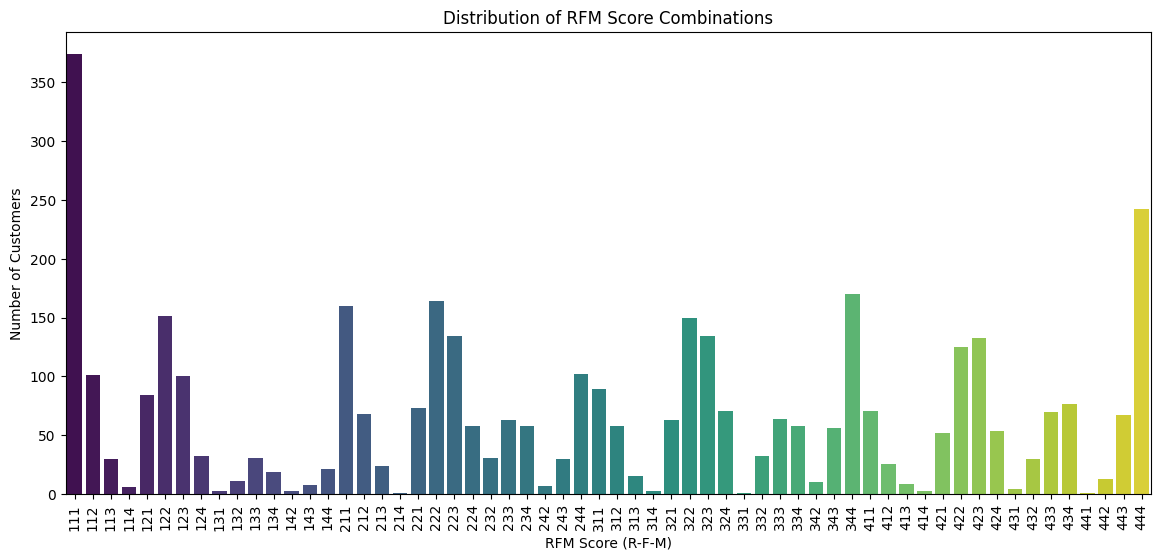

In [ ]:
# Count distribution of RFM Score combinations
rfm_counts = df_rfm['RFM_Score'].value_counts().sort_index()

plt.figure(figsize=(14,6))
sns.barplot(x=rfm_counts.index, y=rfm_counts.values, palette="viridis")
plt.xticks(rotation=90)
plt.title("Distribution of RFM Score Combinations")
plt.xlabel("RFM Score (R-F-M)")
plt.ylabel("Number of Customers")
plt.show()


#### Summary Evaluation of RFM Score Distribution

#### 1. General Distribution
- The chart shows 64 possible RFM score combinations (from 111 to 444)
- The distribution is highly uneven: a few combinations dominate while many others have very small counts

#### 2. Key Observations
##### Dominant Segments
- 111 has the largest count (≈ 370+ customers)
  - Represents customers with worst Recency, lowest Frequency, and lowest Monetary
  - These are Lost Customers → inactive, low-value
- Segment 444 is strong (≈240 customers)
  - Customers with the best Recency, highest Frequency, and highest Monetary
  - Represents Champions who are highly engaged, loyal, and valuable
- Mid-range clusters such as 222, 322, 344, and 422 have moderate sizes (100–170 customers)
  - These represent average or potential customers
  - Likely candidates for conversion into loyal customers with the right engagement strategy
- Long tail of small groups (e.g., 131, 243, 331, etc. with <20 customers)
  - Indicates that not all theoretical RFM profiles are well represented in the dataset
  - These profiles are rare and less impactful but may reveal niche behaviors

### A.4: Define Customer Segments (Rule-based Mapping)

In [ ]:
def segment_customer(row):
    if row['R_Score'] == 4 and row['F_Score'] == 4 and row['M_Score'] == 4:
        return 'Champions'
    elif row['F_Score'] >= 3 and row['M_Score'] >= 3:
        return 'Loyal Customers'
    elif row['R_Score'] >= 3 and row['F_Score'] >= 2:
        return 'Potential Loyalists'
    elif row['R_Score'] == 1 and row['F_Score'] >= 3:
        return 'At Risk'
    elif row['R_Score'] == 1 and row['M_Score'] >= 3:
        return 'Can’t Lose Them'
    elif row['R_Score'] == 1 and row['F_Score'] == 1 and row['M_Score'] == 1:
        return 'Hibernating'
    else:
        return 'Need Attention'

df_rfm['Segment'] = df_rfm.apply(segment_customer, axis=1)
print("Customer Segment Counts:")
print(df_rfm['Segment'].value_counts())

Customer Segment Counts:
Segment
Need Attention         1330
Loyal Customers         894
Potential Loyalists     873
Hibernating             374
Champions               242
Can’t Lose Them         168
At Risk                  17
Name: count, dtype: int64


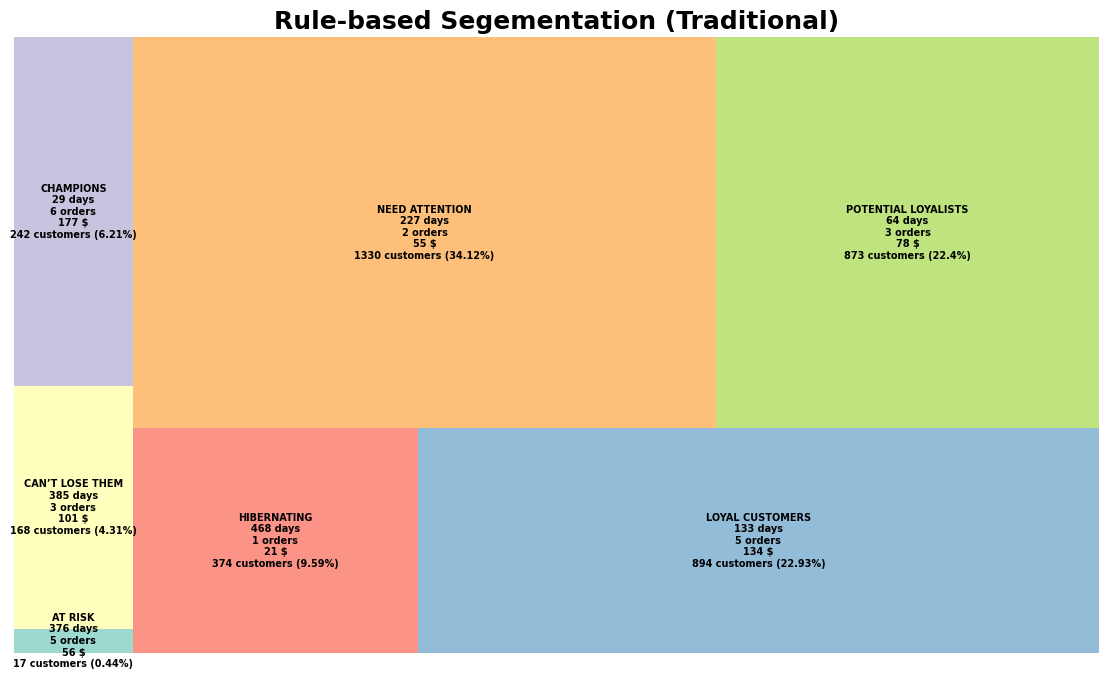

In [ ]:
segment_summary = df_rfm.groupby('Segment').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'Monetary': 'mean',
    'Member_number': 'count'
}).reset_index()

total_customers = segment_summary['Member_number'].sum()
segment_summary['Percent'] = (segment_summary['Member_number'] / total_customers * 100).round(2)

labels = [
    f"{row['Segment'].upper()}\n"
    f"{int(row['Recency'])} days\n"
    f"{int(row['Frequency'])} orders\n"
    f"{int(row['Monetary'])} $\n"
    f"{row['Member_number']} customers ({row['Percent']}%)"
    for _, row in segment_summary.iterrows()
]

plt.figure(figsize=(14,8))
squarify.plot(
    sizes=segment_summary['Member_number'],
    label=labels,
    color=sns.color_palette("Set3", len(segment_summary)),
    alpha=0.85,
    text_kwargs={'fontsize':7, 'weight':'bold'}
)

plt.title("Rule-based Segementation (Traditional)", fontsize=18, weight="bold")
plt.axis("off")
plt.show()



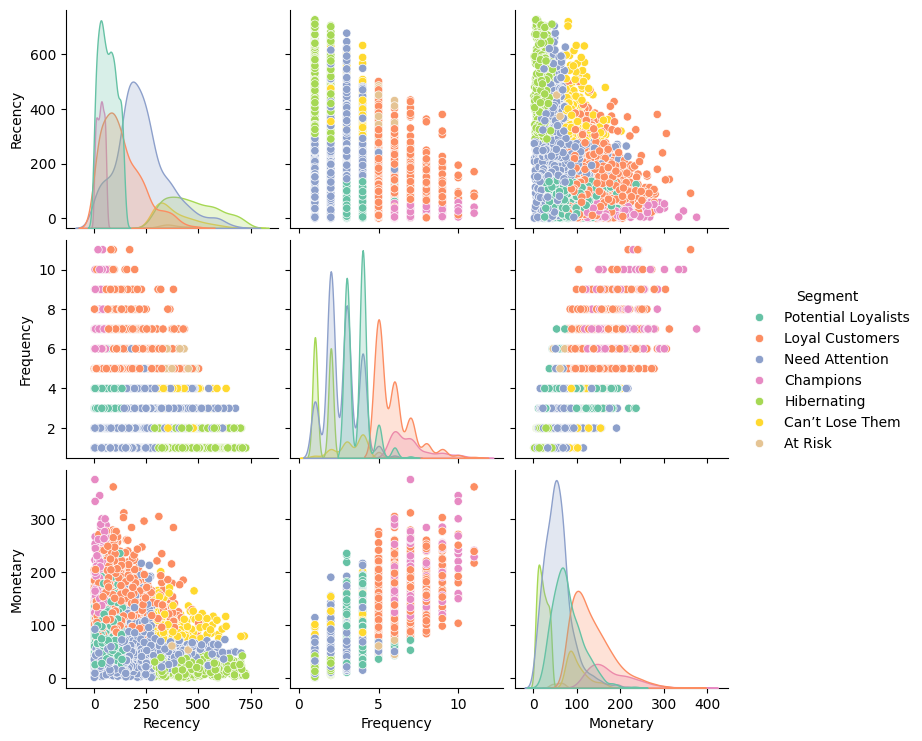

In [ ]:
sns.pairplot(
    df_rfm,
    hue="Segment",
    vars=["Recency", "Frequency", "Monetary"],
    palette="Set2",
    diag_kind="kde"
)

plt.show()


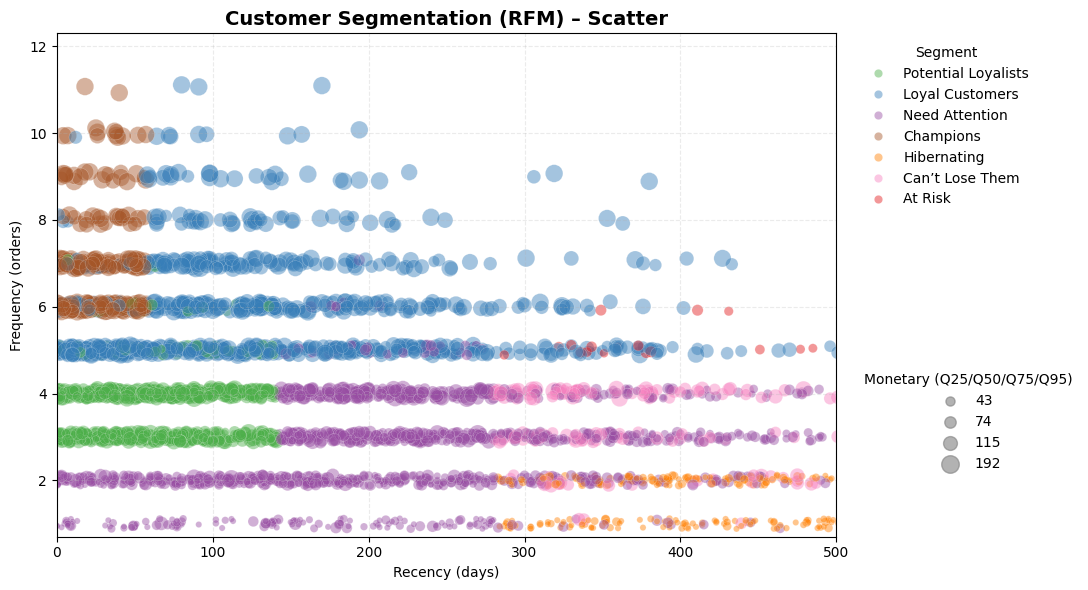

In [ ]:
df = df_rfm.copy()
custom_palette = {
    "Champions": "#a65628",
    "Loyal Customers": "#377eb8",
    "Potential Loyalists": "#4daf4a",
    "Need Attention": "#984ea3",
    "Hibernating": "#ff7f00",
    "Can’t Lose Them": "#f781bf",
    "At Risk": "#E41A1C"
}
rng = np.random.default_rng(seed=42)
df["Frequency_jit"] = df["Frequency"] + rng.uniform(-0.12, 0.12, len(df))
q05, q95 = df["Monetary"].quantile([0.05, 0.95])
size_norm = Normalize(vmin=q05, vmax=q95)
plt.figure(figsize=(11, 6))
ax = sns.scatterplot(
    data=df,
    x="Recency", y="Frequency_jit",
    hue="Segment",
    size="Monetary", size_norm=size_norm, sizes=(20, 160),
    alpha=0.45, edgecolor="white", linewidth=0.25,
    palette=custom_palette
)

ax.set_title("Customer Segmentation (RFM) – Scatter", fontsize=14, weight="bold")
ax.set_xlabel("Recency (days)")
ax.set_ylabel("Frequency (orders)")
ax.set_xlim(0, 500)
ax.set_ylim(0.7, 12.3)
ax.grid(True, ls="--", alpha=0.25)

# Legend cho Segment
handles, labels = ax.get_legend_handles_labels()
seg_names = list(df["Segment"].unique())
seg_pairs = [(h, l) for h, l in zip(handles, labels) if l in seg_names]
seg_handles, seg_labels = zip(*seg_pairs)
leg1 = ax.legend(seg_handles, seg_labels, title="Segment",
                 bbox_to_anchor=(1.02, 1), loc="upper left", frameon=False)

# Legend cho Monetary size
qs = np.quantile(df["Monetary"], [0.25, 0.50, 0.75, 0.95])
sizes = [np.interp(v, [q05, q95], [20, 160]) for v in qs]
handles2 = [plt.scatter([], [], s=s, facecolor="gray", edgecolor="gray", alpha=0.6)
            for s in sizes]
labels2 = [f"{int(v):,}" for v in qs]
leg2 = ax.legend(handles2, labels2, title="Monetary (Q25/Q50/Q75/Q95)",
                 scatterpoints=1, bbox_to_anchor=(1.02, 0.35),
                 loc="upper left", frameon=False)
ax.add_artist(leg1)

plt.tight_layout()
plt.show()


### SUMMARY
### Segmentation Rules
The following rules were applied based on RFM scores:
- Champions: R=4, F=4, M=4 → customers with the best recency, frequency, and monetary values
- Loyal Customers: F ≥ 3 and M ≥ 3 → frequent buyers with high spending
- Potential Loyalists: R ≥ 3 and F ≥ 2 → recent buyers with good frequency, candidates for loyalty programs
- At Risk: R=1 and F ≥ 3 → used to be frequent buyers, but haven’t purchased for a long time
- Can’t Lose Them: R=1 and M ≥ 3 → previously high spenders who are now inactive
- Hibernating: R=1, F=1, M=1 → inactive, low-value customers
- Need Attention: all other customers not covered above, generally mid-level engagement

### Segment Distribution
- Champions (light brown): Positioned on the left side with low Recency (recent purchases), high Frequency, and large Monetary values. This is the VIP group that must be retained and rewarded with special perks
- Loyal Customers (blue): Spread more widely than Champions, with stable Frequency (4–8 orders) but varying Recency. This is the core revenue foundation due to their size and loyalty
- Potential Loyalists (green): Concentrated around mid-level Frequency (3–4 orders) and fairly good Recency (<200 days). This group has potential to be converted into Loyal Customers or Champions → should be targeted with loyalty programs and incentives
- Need Attention (light purple): Dominant group, often located in higher Recency ranges (200–400 days) with low–medium Frequency. This is a “half-engaged” segment → large in size but weak in activity
- At Risk (dark red): Small but very distinct. These customers had high Frequency in the past but now show long Recency → once valuable, now at risk of churn
- Can’t Lose Them (pink): High Monetary spenders historically, but now with poor Recency and lower Frequency. This group used to spend significantly but rarely return now → requires win-back campaigns
- Hibernating (orange): Scattered at high Recency (>300 days), low Frequency, and low Monetary. These are “sleeping” low-value customers → lower priority for reactivation

### Key Observations
- Need Attention dominates (34%) → largest group; these customers show moderate activity but need campaigns to increase engagement
- Loyal Customers + Potential Loyalists together make up ~45% → a strong opportunity for retention and upselling
- Champions (6.2%) are small but highly valuable → key customers to nurture and reward
- Hibernating (9.6%) and Can’t Lose Them (4.3%) indicate a significant portion of inactive customers → risk of churn
- At Risk is very small (<1%) → rare but high-priority to reactivate since they used to be frequent

### Key Insights
- Loyal Customers + Potential Loyalists dominate → their spread across the scatter plot highlights a huge opportunity for upselling and cross-selling
- Champions are fewer but extremely valuable → need dedicated VIP care and exclusive rewards
- Need Attention & Hibernating are numerous → engagement costs could be high, so marketing resources should be allocated carefully
- At Risk & Can’t Lose Them, although small in size, are highly strategic → personalized reactivation campaigns (e.g., vouchers, direct calls, exclusive offers) should be prioritized
- Monetary (bubble size) trend: Champions and Loyal Customers clearly hold the largest values, while Hibernating is the smallest → proving that segmentation reflects real business value

### Summary & Strategic Direction
The visualization highlights three customer value tiers:

- High-value tier: Champions, Loyal Customers → must be nurtured with exclusive programs and retention initiatives.

- Mid-value tier: Potential Loyalists, Need Attention → should be developed through targeted engagement and loyalty-building campaigns.

- Low-value tier: At Risk, Can’t Lose Them, Hibernating → require selective reactivation strategies, with ROI-driven prioritization.

→ Businesses should invest ~70% of resources in Champions, Loyal Customers, and Potential Loyalists, while maintaining a smaller but focused reactivation effort for At Risk and Can’t Lose Them.

## B. RFM + KMeans Clustering

In [ ]:
df_rfm = rfm.copy()
scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(df_rfm)

In [ ]:
inertia = []
silhouette = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters = k, random_state = 5)
    kmeans.fit(rfm_scaled)
    inertia.append(kmeans.inertia_)
    silhouette.append(silhouette_score(rfm_scaled, kmeans.labels_))

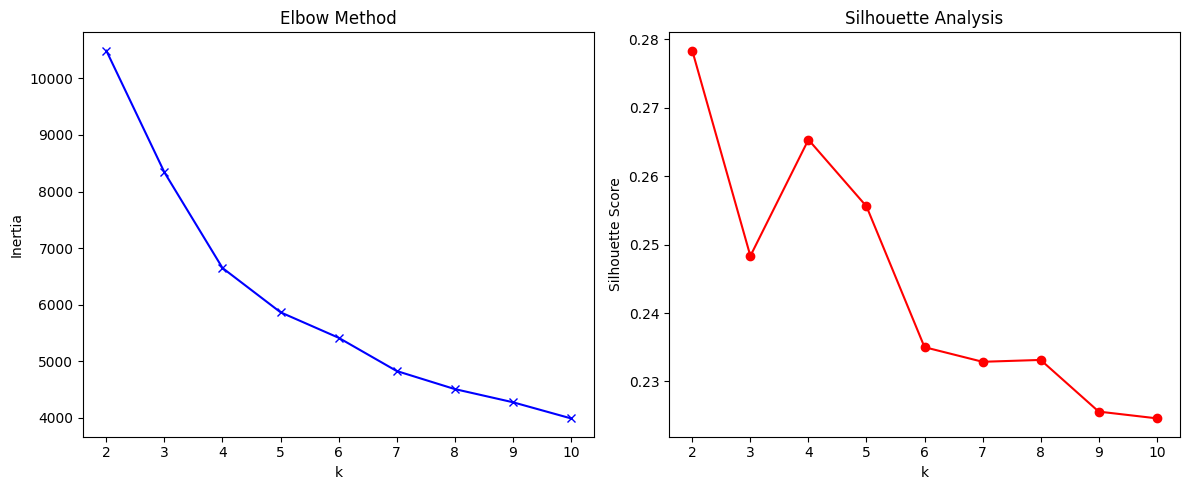

In [ ]:
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

axes[0].plot(K, inertia, 'bx-')
axes[0].set_xlabel('k')
axes[0].set_ylabel('Inertia')
axes[0].set_title('Elbow Method')

axes[1].plot(K, silhouette, 'ro-')
axes[1].set_xlabel('k')
axes[1].set_ylabel('Silhouette Score')
axes[1].set_title('Silhouette Analysis')

plt.tight_layout()
plt.show()

* The bend, or the point of diminishing returns, is around k = 3 ~ 4

* For Silhouette Score, k = 3 is also the sweet spot: it aligns with the elbow and keeps a high silhouette without collapsing everything into only two groups

* k = 4 adds granularity, the extra split may be less stable/distinct due to the noticeable drop in Silhouette Score. Here, we need to verify that the two "middle" clusters are truly different in RFM and in behavior

### B.1 3 Clusters

In [ ]:
# 1. Fit KMeans
kmeans = KMeans(n_clusters=3, random_state=5)
df_rfm["KMeansCluster_3"] = kmeans.fit_predict(rfm_scaled)

# 2. Cluster size distribution
print("Cluster size distribution:")
print(df_rfm["KMeansCluster_3"].value_counts())

# 3. Cluster mean values
cluster_profile = df_rfm.groupby("KMeansCluster_3")[["Recency","Frequency","Monetary"]].mean()
print("\nCluster profiles (original labels):")
print(cluster_profile)

# 4. Create a composite score to re-order clusters
cluster_profile["ClusterScore"] = (
    -cluster_profile["Recency"] +
     cluster_profile["Frequency"] +
     cluster_profile["Monetary"]
)

# 5. Sort clusters by score (highest value customers → label 0)
cluster_profile = cluster_profile.sort_values("ClusterScore", ascending=False)

# 6. Create mapping old → new labels
mapping = {old: new for new, old in enumerate(cluster_profile.index)}
print("\nCluster mapping (old → new):", mapping)

# 7. Apply mapping
df_rfm["Cluster_3_Normalized"] = df_rfm["KMeansCluster_3"].map(mapping)

# 8. Show normalized results
print("\nCluster size distribution (normalized):")
print(df_rfm["Cluster_3_Normalized"].value_counts())

print("\nCluster profiles (normalized labels):")
print(df_rfm.groupby("Cluster_3_Normalized")[["Recency","Frequency","Monetary"]].mean())

Cluster size distribution:
KMeansCluster_3
2    1838
0    1102
1     958
Name: count, dtype: int64

Cluster profiles (original labels):
                    Recency  Frequency    Monetary
KMeansCluster_3                                   
0                107.509074   6.058076  152.652260
1                414.489562   2.281837   43.677150
2                117.575626   3.319369   66.427709

Cluster mapping (old → new): {0: 0, 2: 1, 1: 2}

Cluster size distribution (normalized):
Cluster_3_Normalized
1    1838
0    1102
2     958
Name: count, dtype: int64

Cluster profiles (normalized labels):
                         Recency  Frequency    Monetary
Cluster_3_Normalized                                   
0                     107.509074   6.058076  152.652260
1                     117.575626   3.319369   66.427709
2                     414.489562   2.281837   43.677150


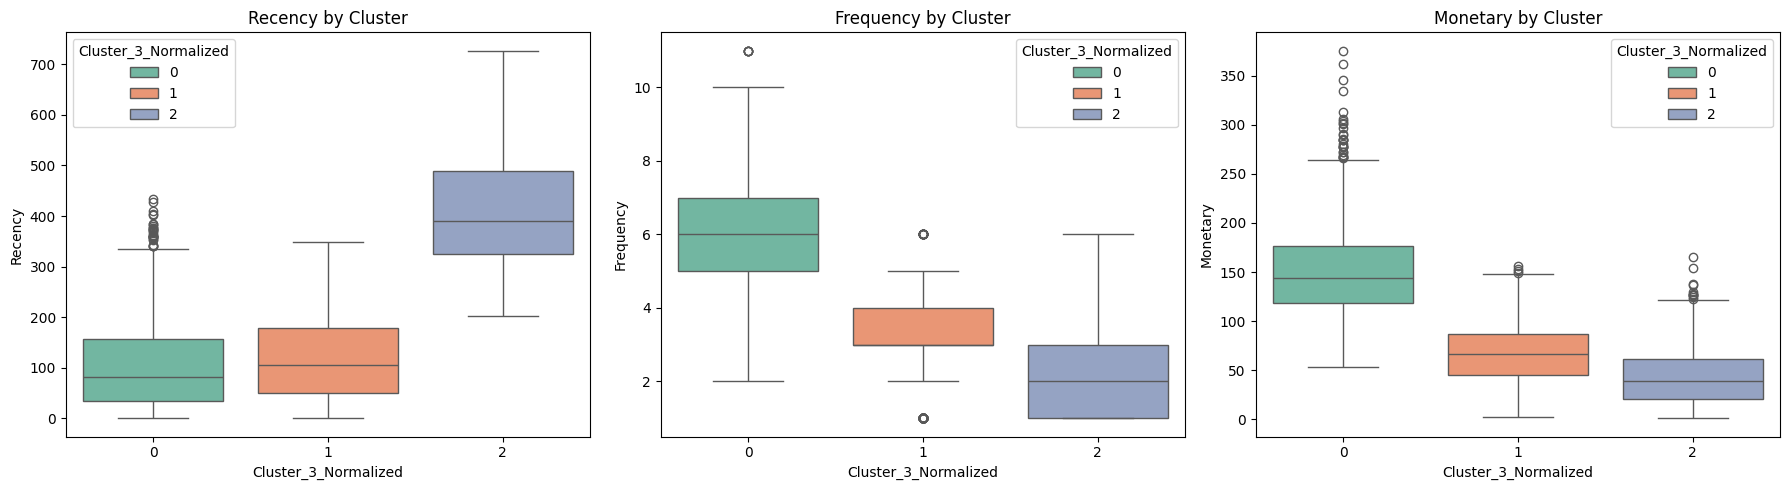

In [ ]:
plt.figure(figsize = (18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data = df_rfm, x = "Cluster_3_Normalized", y = "Recency", hue = "Cluster_3_Normalized", palette = "Set2")
plt.title("Recency by Cluster")

plt.subplot(1, 3, 2)
sns.boxplot(data = df_rfm, x = "Cluster_3_Normalized", y = "Frequency", hue = "Cluster_3_Normalized", palette = "Set2")
plt.title("Frequency by Cluster")

plt.subplot(1, 3, 3)
sns.boxplot(data = df_rfm, x = "Cluster_3_Normalized", y = "Monetary", hue = "Cluster_3_Normalized", palette = "Set2")
plt.title("Monetary by Cluster")

plt.tight_layout()
plt.show()

* **Cluster 0 (Best / Loyal):** recent buyers, high frequency, high monetary (many high-value outliers).

* **Cluster 1 (Medium / Potential):** middle/occasional buyers with moderate recency, frequency and spending.

* **Cluster 2 (Lapsed / Low-value):** long time since last purchase, low frequency, low spend.

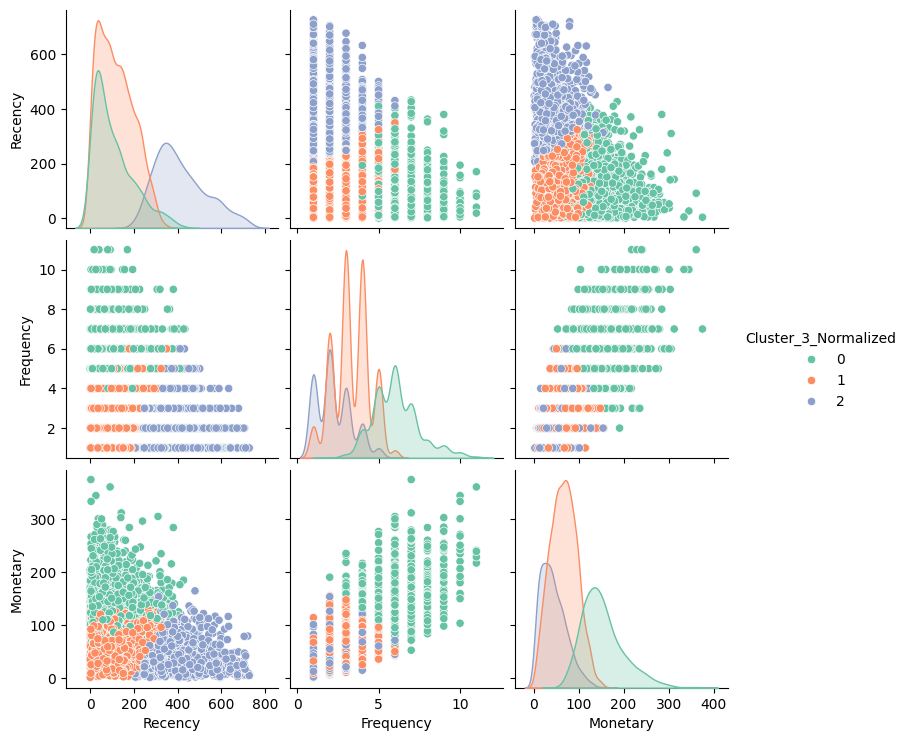

In [ ]:
sns.pairplot(df_rfm, hue = "Cluster_3_Normalized", vars = ["Recency","Frequency","Monetary"], palette = "Set2")
plt.show()

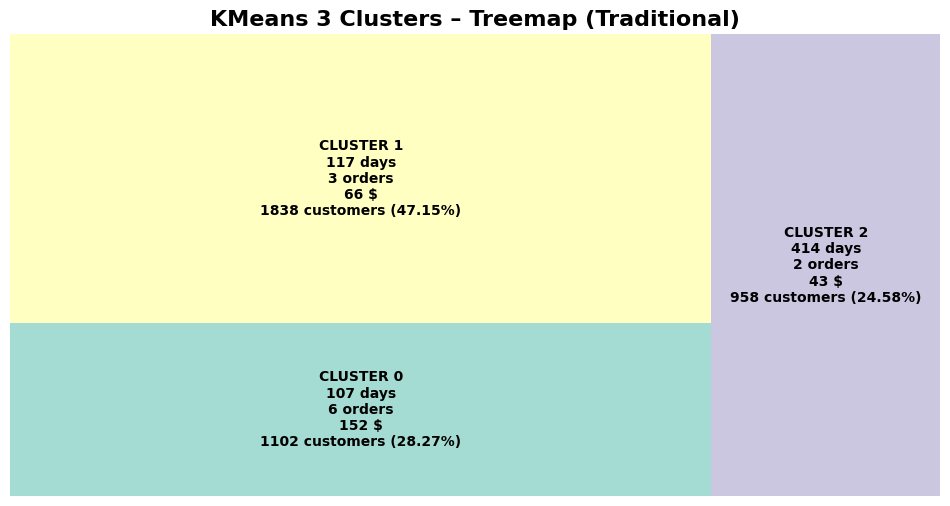

In [ ]:
# --- Step 1: Compute summary statistics for each cluster ---
cluster_summary = df_rfm.groupby("Cluster_3_Normalized").agg(
    Recency=("Recency", "mean"),        # Average recency
    Frequency=("Frequency", "mean"),    # Average frequency
    Monetary=("Monetary", "mean"),      # Average monetary
    Count=("Cluster_3_Normalized", "count")  # Number of customers in the cluster
).reset_index()

# --- Step 2: Add percentage of customers per cluster ---
total_customers = cluster_summary["Count"].sum()
cluster_summary["Percent"] = 100 * cluster_summary["Count"] / total_customers

# --- Step 3: Create labels for treemap display ---
labels = [
    (f"CLUSTER {row.Cluster_3_Normalized}\n"        # Cluster ID
     f"{int(row.Recency)} days\n"              # Average recency
     f"{int(row.Frequency)} orders\n"          # Average frequency
     f"{int(row.Monetary)} $\n"                # Average monetary
     f"{row.Count} customers ({row.Percent:.2f}%)")  # Count and percentage
    for row in cluster_summary.itertuples()
]

# --- Step 4: Plot treemap ---
plt.figure(figsize=(12, 6))
squarify.plot(
    sizes=cluster_summary["Count"],             # Rectangle size = number of customers
    label=labels,                               # Labels defined above
    alpha=0.8,
    color=plt.cm.Set3(range(len(cluster_summary))),
    text_kwargs={"fontsize": 10, "weight": "bold"}
)
plt.axis("off")
plt.title("KMeans 3 Clusters – Treemap (Traditional)", fontsize=16, weight="bold")
plt.show()

In [ ]:
labels = df_rfm['Cluster_3_Normalized'].values
df_rfm['silhouette_3'] = silhouette_samples(rfm_scaled, labels)
display(df_rfm['silhouette_3'].mean())
display(df_rfm.groupby('Cluster_3_Normalized')['silhouette_3'].mean())
display(silhouette_score(rfm_scaled, labels))
df_rfm.groupby('Cluster_3_Normalized')[['Recency', 'Frequency', 'Monetary']].describe().T

np.float64(0.24834726396804338)

,silhouette_3
Cluster_3_Normalized,
0,0.226454
1,0.256345
2,0.258187


np.float64(0.24834726396804338)

Cluster_3_Normalized            0            1           2
Recency   count       1102.000000  1838.000000  958.000000
          mean         107.509074   117.575626  414.489562
          std           92.033518    79.757434  117.644264
          min            0.000000     0.000000  203.000000
          25%           35.000000    49.000000  325.000000
          50%           82.000000   106.000000  391.000000
          75%          155.750000   178.000000  489.000000
          max          433.000000   349.000000  727.000000
Frequency count       1102.000000  1838.000000  958.000000
          mean           6.058076     3.319369    2.281837
          std            1.413662     1.106110    1.088509
          min            2.000000     1.000000    1.000000
          25%            5.000000     3.000000    1.000000
          50%            6.000000     3.000000    2.000000
          75%            7.000000     4.000000    3.000000
          max           11.000000     6.000000    6.000000
Monetary  count       1102.000000  1838.000000  958.000000
          mean         152.652260    66.427709   43.677150
          std           46.762179    29.238247   28.262915
          min           53.350000     2.200000    1.300000
          25%          118.800000    45.355000   21.000000
          50%          144.395000    66.375000   38.700000
          75%          176.930000    86.637500   61.300000
          max          375.310000   155.900000  165.350000

###B.2 4 clusters

In [ ]:
# 1. Fit KMeans
kmeans = KMeans(n_clusters=4, random_state=5)
df_rfm["KMeansCluster_4"] = kmeans.fit_predict(rfm_scaled)

# 2. Cluster size distribution
print("Cluster size distribution:")
print(df_rfm["KMeansCluster_4"].value_counts())

# 3. Cluster mean values
cluster_profile = df_rfm.groupby("KMeansCluster_4")[["Recency","Frequency","Monetary"]].mean()
print("\nCluster profiles (original labels):")
print(cluster_profile)

# 4. Create a composite score to re-order clusters
cluster_profile["ClusterScore"] = (
    -cluster_profile["Recency"] +
     cluster_profile["Frequency"] +
     cluster_profile["Monetary"]
)

# 5. Sort clusters by score (highest value customers → label 0)
cluster_profile = cluster_profile.sort_values("ClusterScore", ascending=False)

# 6. Create mapping old → new labels
mapping = {old: new for new, old in enumerate(cluster_profile.index)}
print("\nCluster mapping (old → new):", mapping)

# 7. Apply mapping
df_rfm["Cluster_4_Normalized"] = df_rfm["KMeansCluster_4"].map(mapping)

# 8. Show normalized results
print("\nCluster size distribution (normalized):")
print(df_rfm["Cluster_4_Normalized"].value_counts())

print("\nCluster profiles (normalized labels):")
print(df_rfm.groupby("Cluster_4_Normalized")[["Recency","Frequency","Monetary"]].mean())

Cluster size distribution:
KMeansCluster_4
1    1153
2    1109
0     868
3     768
Name: count, dtype: int64

Cluster profiles (original labels):
                    Recency  Frequency    Monetary
KMeansCluster_4                                   
0                100.237327   6.337558  162.267673
1                132.704250   3.486557   71.719098
2                140.024346   3.458070   70.716745
3                437.967448   2.092448   39.315495

Cluster mapping (old → new): {0: 0, 1: 1, 2: 2, 3: 3}

Cluster size distribution (normalized):
Cluster_4_Normalized
1    1153
2    1109
0     868
3     768
Name: count, dtype: int64

Cluster profiles (normalized labels):
                         Recency  Frequency    Monetary
Cluster_4_Normalized                                   
0                     100.237327   6.337558  162.267673
1                     132.704250   3.486557   71.719098
2                     140.024346   3.458070   70.716745
3                     437.967448   2.092448   

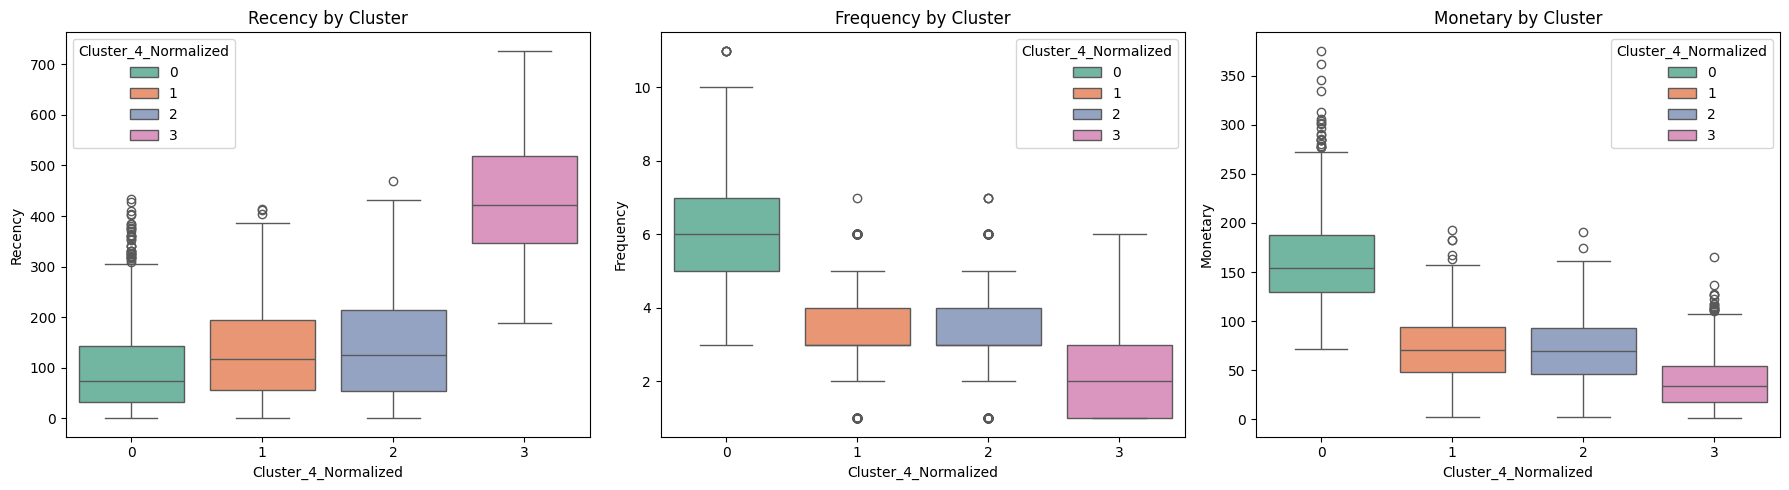

In [ ]:
plt.figure(figsize = (18, 5))

plt.subplot(1, 3, 1)
sns.boxplot(data = df_rfm, x = "Cluster_4_Normalized", y = "Recency", hue = "Cluster_4_Normalized", palette = "Set2")
plt.title("Recency by Cluster")

plt.subplot(1, 3, 2)
sns.boxplot(data = df_rfm, x = "Cluster_4_Normalized", y = "Frequency", hue = "Cluster_4_Normalized", palette = "Set2")
plt.title("Frequency by Cluster")

plt.subplot(1, 3, 3)
sns.boxplot(data = df_rfm, x = "Cluster_4_Normalized", y = "Monetary", hue = "Cluster_4_Normalized", palette = "Set2")
plt.title("Monetary by Cluster")

plt.tight_layout()
plt.show()

* **Cluster 0 (Champions / VIPs):** Low Recency (shop recently), high Frequency, high Monetary. Small or medium-sized group but very valuable (high spend per visit). Our business focus should be to retain and reward them.

* **Cluster 1 (Occasional / Bargain Shoppers):** Moderate Recency, lower Frequency and lower Monetary than regulars. They shop sometimes but spend little, so they are likely price-sensitive or shopping for specific low-cost items.

* **Cluster 2 (Regulars / Growth Targets):** Moderate Recency, moderate-to-high Frequency, medium Monetary. Good candidates for cross-sell and upsell to increase basket size and frequency.

* **Cluster 3 (Lapsed / At-Risk):** High Recency (haven't shopped in a long time), low Frequency, very low Monetary.Priority: reactivation.

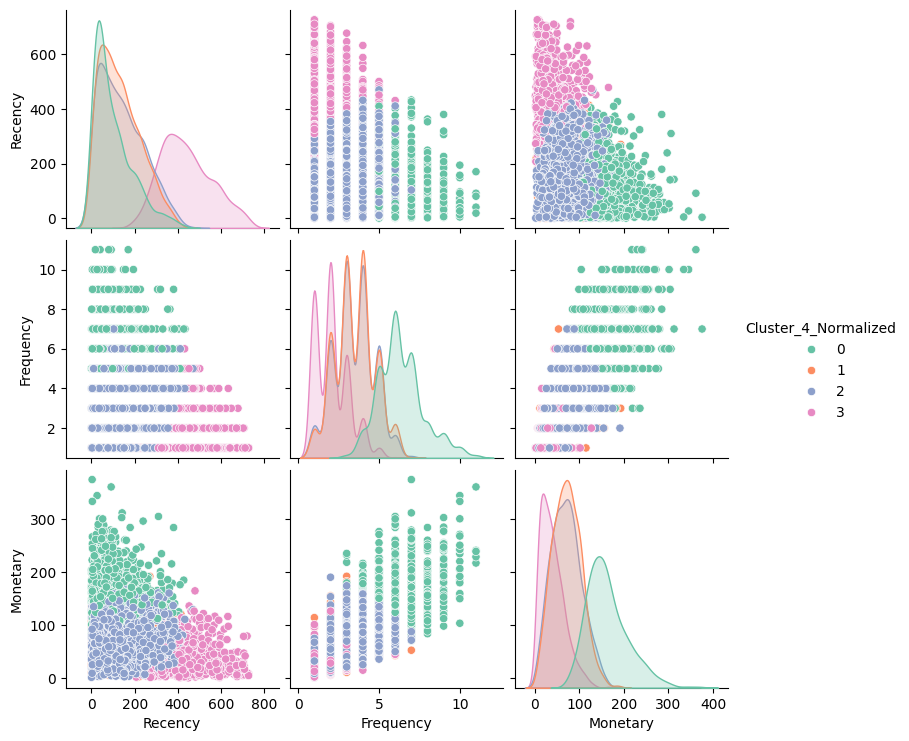

In [ ]:
sns.pairplot(df_rfm, hue = "Cluster_4_Normalized", vars = ["Recency","Frequency","Monetary"], palette = "Set2")
plt.show()

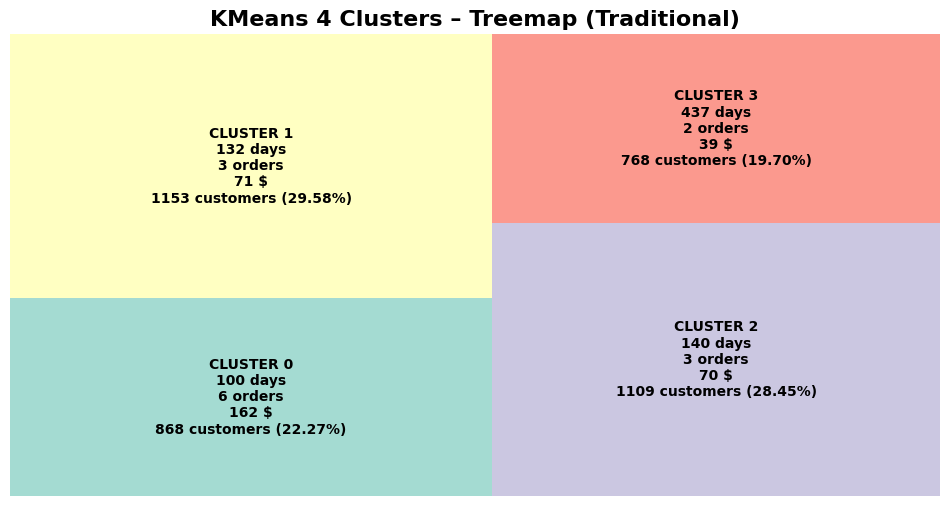

In [ ]:
# --- Step 1: Compute summary statistics for each cluster ---
cluster_summary = df_rfm.groupby("Cluster_4_Normalized").agg(
    Recency=("Recency", "mean"),        # Average recency
    Frequency=("Frequency", "mean"),    # Average frequency
    Monetary=("Monetary", "mean"),      # Average monetary
    Count=("Cluster_4_Normalized", "count")  # Number of customers in the cluster
).reset_index()

# --- Step 2: Add percentage of customers per cluster ---
total_customers = cluster_summary["Count"].sum()
cluster_summary["Percent"] = 100 * cluster_summary["Count"] / total_customers

# --- Step 3: Create labels for treemap display ---
labels = [
    (f"CLUSTER {row.Cluster_4_Normalized}\n"        # Cluster ID
     f"{int(row.Recency)} days\n"              # Average recency
     f"{int(row.Frequency)} orders\n"          # Average frequency
     f"{int(row.Monetary)} $\n"                # Average monetary
     f"{row.Count} customers ({row.Percent:.2f}%)")  # Count and percentage
    for row in cluster_summary.itertuples()
]

# --- Step 4: Plot treemap ---
plt.figure(figsize=(12, 6))
squarify.plot(
    sizes=cluster_summary["Count"],             # Rectangle size = number of customers
    label=labels,                               # Labels defined above
    alpha=0.8,
    color=plt.cm.Set3(range(len(cluster_summary))),
    text_kwargs={"fontsize": 10, "weight": "bold"}
)
plt.axis("off")
plt.title("KMeans 4 Clusters – Treemap (Traditional)", fontsize=16, weight="bold")
plt.show()

In [ ]:
labels = df_rfm['Cluster_4_Normalized'].values
df_rfm['silhouette_4'] = silhouette_samples(rfm_scaled, labels)
display(df_rfm['silhouette_4'].mean())
display(df_rfm.groupby('Cluster_4_Normalized')['silhouette_4'].describe())
display(silhouette_score(rfm_scaled, labels))
df_rfm.groupby('Cluster_4_Normalized')[['Recency', 'Frequency', 'Monetary']].describe().T

np.float64(0.26535201511445067)

,count,mean,std,min,25%,50%,75%,max
Cluster_4_Normalized,,,,,,,,
0,868.0,0.204019,0.159768,-0.110361,0.073219,0.226591,0.340291,0.471400
1,1153.0,0.300509,0.137981,0.014318,0.188028,0.314351,0.418042,0.530617
2,1109.0,0.282885,0.136023,-0.015761,0.174587,0.292160,0.398269,0.516363
3,768.0,0.256571,0.160574,-0.057398,0.120904,0.280543,0.390122,0.521717


np.float64(0.26535201511445067)

Cluster_4_Normalized           0            1            2           3
Recency   count       868.000000  1153.000000  1109.000000  768.000000
          mean        100.237327   132.704250   140.024346  437.967448
          std          89.257498    93.039811   101.184280  118.002476
          min           0.000000     0.000000     0.000000  188.000000
          25%          32.000000    56.000000    54.000000  346.000000
          50%          73.000000   118.000000   125.000000  422.500000
          75%         143.000000   194.000000   214.000000  518.000000
          max         433.000000   414.000000   470.000000  727.000000
Frequency count       868.000000  1153.000000  1109.000000  768.000000
          mean          6.337558     3.486557     3.458070    2.092448
          std           1.400319     1.205471     1.203672    1.010013
          min           3.000000     1.000000     1.000000    1.000000
          25%           5.000000     3.000000     3.000000    1.000000
          50%           6.000000     3.000000     3.000000    2.000000
          75%           7.000000     4.000000     4.000000    3.000000
          max          11.000000     7.000000     7.000000    6.000000
Monetary  count       868.000000  1153.000000  1109.000000  768.000000
          mean        162.267673    71.719098    70.716745   39.315495
          std          46.675232    31.648381    33.592931   26.733382
          min          71.670000     2.700000     2.200000    1.300000
          25%         129.580000    48.300000    45.920000   18.000000
          50%         154.520000    70.800000    69.300000   34.320000
          75%         187.575000    94.350000    92.620000   54.595000
          max         375.310000   192.850000   191.100000  165.350000

* For both values of k, the clustering outcomes are reasonable but not perfect. Customers are somewhat grouped, but boundaries between segments are fuzzy.

## C. RFM + Hierarchical Clustering

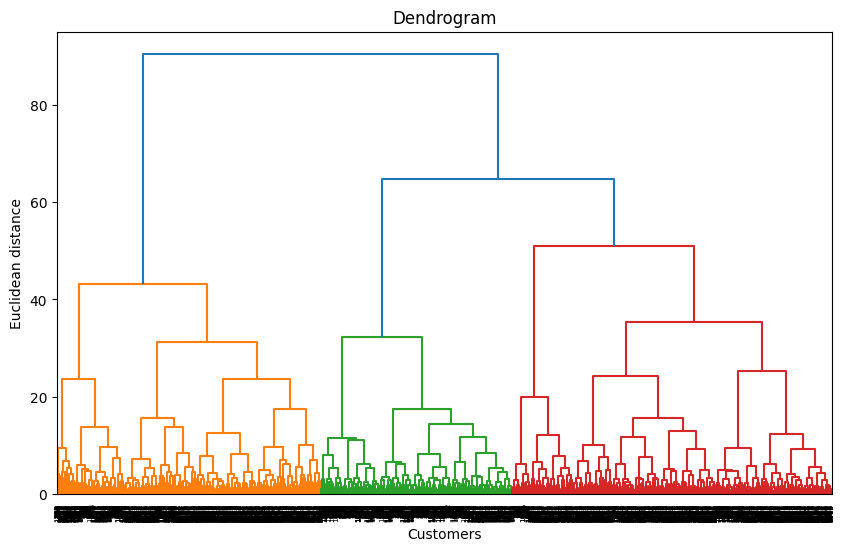

In [ ]:
plt.figure(figsize = (10, 6))
dendrogram = sch.dendrogram(sch.linkage(rfm_scaled, method = 'ward'))
plt.title("Dendrogram")
plt.xlabel("Customers")
plt.ylabel("Euclidean distance")
plt.show()

In [ ]:
hc = AgglomerativeClustering(n_clusters = 4, metric = 'euclidean', linkage = 'ward')
df_rfm['HCCluster'] = hc.fit_predict(rfm_scaled)
display(df_rfm.HCCluster.value_counts())
df_rfm.groupby("HCCluster")[["Recency", "Frequency", "Monetary"]].mean()

,count
HCCluster,
0,1330
1,1304
2,960
3,304


,Recency,Frequency,Monetary
HCCluster,,,
0,123.043609,5.581203,138.885474
1,203.653374,2.611196,48.860905
2,142.658333,3.782292,77.989937
3,544.394737,1.657895,29.134836


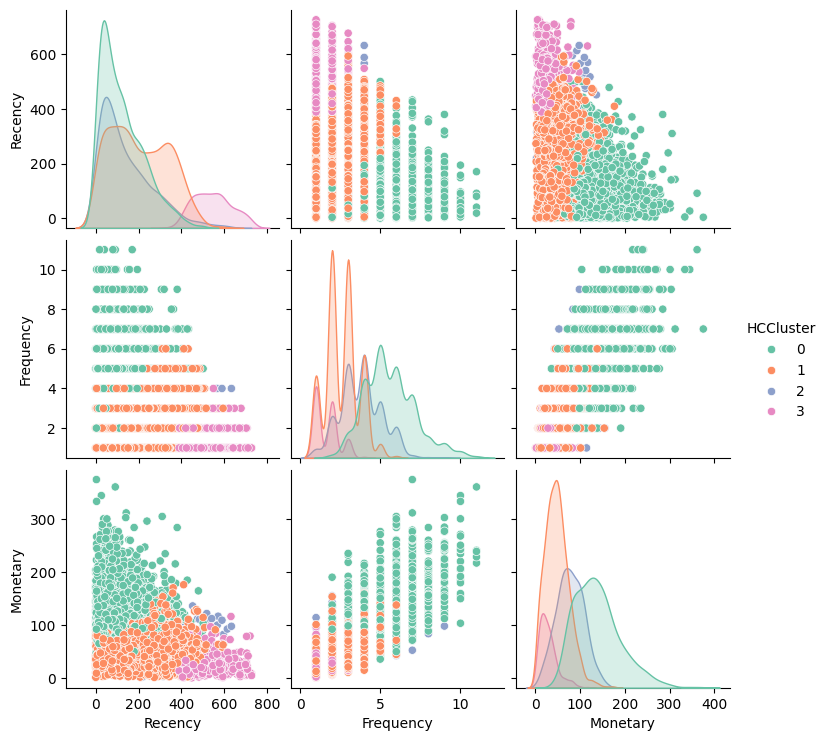

In [ ]:
sns.pairplot(df_rfm, hue = "HCCluster", vars = ["Recency","Frequency","Monetary"], palette = "Set2")
plt.show()

In [ ]:
labels = df_rfm['HCCluster'].values
df_rfm['silhouette_hc'] = silhouette_samples(rfm_scaled, labels)
display(df_rfm.groupby('HCCluster')['silhouette_hc'].mean())
display(silhouette_score(rfm_scaled, labels))
df_rfm.groupby('HCCluster')[['Recency', 'Frequency', 'Monetary']].describe().T

,silhouette_hc
HCCluster,
0,0.118141
1,0.153559
2,0.263293
3,0.400017


np.float64(0.18772045021073624)

HCCluster                  0            1           2           3
Recency   count  1330.000000  1304.000000  960.000000  304.000000
          mean    123.043609   203.653374  142.658333  544.394737
          std      99.842033   133.284649  122.739141   87.007276
          min       0.000000     0.000000    0.000000  338.000000
          25%      41.000000    88.750000   45.000000  474.000000
          50%      98.000000   187.000000  103.000000  542.000000
          75%     186.000000   319.000000  213.000000  601.250000
          max     501.000000   594.000000  633.000000  727.000000
Frequency count  1330.000000  1304.000000  960.000000  304.000000
          mean      5.581203     2.611196    3.782292    1.657895
          std       1.583809     1.011779    1.271119    0.723078
          min       2.000000     1.000000    1.000000    1.000000
          25%       4.000000     2.000000    3.000000    1.000000
          50%       5.000000     3.000000    4.000000    2.000000
          75%       7.000000     3.000000    5.000000    2.000000
          max      11.000000     6.000000    9.000000    4.000000
Monetary  count  1330.000000  1304.000000  960.000000  304.000000
          mean    138.885474    48.860905   77.989937   29.134836
          std      51.742959    26.519111   30.645680   19.891064
          min      36.600000     2.100000    2.700000    1.300000
          25%      99.215000    29.775000   57.275000   14.500000
          50%     132.750000    46.700000   77.310000   25.000000
          75%     166.535000    63.925000  100.100000   37.900000
          max     375.310000   176.950000  167.900000  117.060000